## LASSO and Ridge Regression

(a) Download the Communities and Crime data from https://archive.ics.uci.edu/ml/datasets/Communities+and+Crime.

Use the first 1495 rows of data as the training set and the rest as the test set.

In [55]:
import csv
import io
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import variation
from xgboost.sklearn import XGBRegressor
from sklearn.grid_search import GridSearchCV
from sklearn.preprocessing import scale 
from sklearn.linear_model import LinearRegression, RidgeCV, Ridge, Lasso, LassoCV
from sklearn.cross_validation import cross_val_predict, cross_val_score
from sklearn.model_selection import KFold
from sklearn import model_selection
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, r2_score

In [27]:
headers=pd.read_csv('communities.names' ,skiprows = 40,error_bad_lines=False)[26:154].values.tolist()
headers_list = [item[0].lstrip('@attribute ').rstrip('numeric').rstrip('string').rstrip() for item in headers]
df=pd.read_csv('communities.txt', header=None,na_values='?')
df.columns=headers_list
df.describe()

,state,county,community,fold,population,householdsize,cepctblack,cePctWhite,cePctAsian,cePctHisp,...,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop,ViolentCrimesPerPop
count,1994.000000,820.000000,817.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,...,1994.000000,1994.000000,1994.000000,319.000000,319.000000,319.000000,319.000000,1994.000000,319.000000,1994.000000
mean,28.683551,58.826829,46188.336597,5.493982,0.057593,0.463395,0.179629,0.753716,0.153681,0.144022,...,0.065231,0.232854,0.161685,0.163103,0.076708,0.698589,0.440439,0.094052,0.195078,0.237979
std,16.397553,126.420560,25299.726569,2.873694,0.126906,0.163717,0.253442,0.244039,0.208877,0.232492,...,0.109459,0.203092,0.229055,0.214778,0.140207,0.213944,0.405808,0.240328,0.164718,0.232985
min,1.000000,1.000000,70.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,12.000000,9.000000,25065.000000,3.000000,0.010000,0.350000,0.020000,0.630000,0.040000,0.010000,...,0.020000,0.100000,0.020000,0.040000,0.020000,0.620000,0.000000,0.000000,0.110000,0.070000
50%,34.000000,23.000000,48090.000000,5.000000,0.020000,0.440000,0.060000,0.850000,0.070000,0.040000,...,0.040000,0.170000,0.070000,0.080000,0.030000,0.750000,0.500000,0.000000,0.150000,0.150000
75%,42.000000,59.500000,66660.000000,8.000000,0.050000,0.540000,0.230000,0.940000,0.170000,0.160000,...,0.070000,0.280000,0.190000,0.195000,0.060000,0.840000,1.000000,0.000000,0.220000,0.330000
max,56.000000,840.000000,94597.000000,10.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


(b) The data set has missing values. Use a data imputation technique to deal with
the missing values in the data set.

In [28]:
print("To get an idea how the missing values are distributed in the data set \n")
col=0
for i in df.isnull().sum():
    if i>0:
        print(i,"missing values in ->",df.columns[col]," of type ",df.dtypes[col])
    col=col+1


To get an idea how the missing values are distributed in the data set 

1174 missing values in -> county  of type  float64
1177 missing values in -> community  of type  float64
1 missing values in -> OtherPerCap  of type  float64
1675 missing values in -> LemasSwornFT  of type  float64
1675 missing values in -> LemasSwFTPerPop  of type  float64
1675 missing values in -> LemasSwFTFieldOps  of type  float64
1675 missing values in -> LemasSwFTFieldPerPop  of type  float64
1675 missing values in -> LemasTotalReq  of type  float64
1675 missing values in -> LemasTotReqPerPop  of type  float64
1675 missing values in -> PolicReqPerOffic  of type  float64
1675 missing values in -> PolicPerPop  of type  float64
1675 missing values in -> RacialMatchCommPol  of type  float64
1675 missing values in -> PctPolicWhite  of type  float64
1675 missing values in -> PctPolicBlack  of type  float64
1675 missing values in -> PctPolicHisp  of type  float64
1675 missing values in -> PctPolicAsian  of type  flo

In [29]:
df[df.columns[:5]]=df[df.columns[:5]].astype(str)

In [33]:
df.describe()


,population,householdsize,cepctblack,cePctWhite,cePctAsian,cePctHisp,gePct12t21,gePct12t29,gePct16t24,gePct65up,...,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop,ViolentCrimesPerPop
count,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,...,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000
mean,0.057593,0.463395,0.179629,0.753716,0.153681,0.144022,0.424218,0.493867,0.336264,0.423164,...,0.065231,0.232854,0.161685,0.163103,0.076708,0.698589,0.440439,0.094052,0.195078,0.237979
std,0.126906,0.163717,0.253442,0.244039,0.208877,0.232492,0.155196,0.143564,0.166505,0.179185,...,0.109459,0.203092,0.229055,0.085793,0.056005,0.085459,0.162099,0.240328,0.065796,0.232985
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.010000,0.350000,0.020000,0.630000,0.040000,0.010000,0.340000,0.410000,0.250000,0.300000,...,0.020000,0.100000,0.020000,0.163103,0.076708,0.698589,0.440439,0.000000,0.195078,0.070000
50%,0.020000,0.440000,0.060000,0.850000,0.070000,0.040000,0.400000,0.480000,0.290000,0.420000,...,0.040000,0.170000,0.070000,0.163103,0.076708,0.698589,0.440439,0.000000,0.195078,0.150000
75%,0.050000,0.540000,0.230000,0.940000,0.170000,0.160000,0.470000,0.540000,0.360000,0.530000,...,0.070000,0.280000,0.190000,0.163103,0.076708,0.698589,0.440439,0.000000,0.195078,0.330000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


*Handling Missing values*
* Case deletion
* Imputation
* Use algorithms that Support Missing Values

  *Imputation Techniques*
   * Mean, Median and Mode Imputation
   * Imputation with Regression
   * k-Neareast Neighbor (kNN) Imputation
   * Multiple Imputation using MICE (Multiple Imputation by Chained Equations)

In [30]:
#Imputing Data using Mean
df=df.fillna(df.mean())

Using Mean for imputing missing values, because Mode and Median might fill the data with 0s, since all values are between 0 and 1, with most values as 0. Not using knn for the same reason and for regression it may increase the correlation in variables. 

(c) Plot a correlation matrix for the features in the dataset.

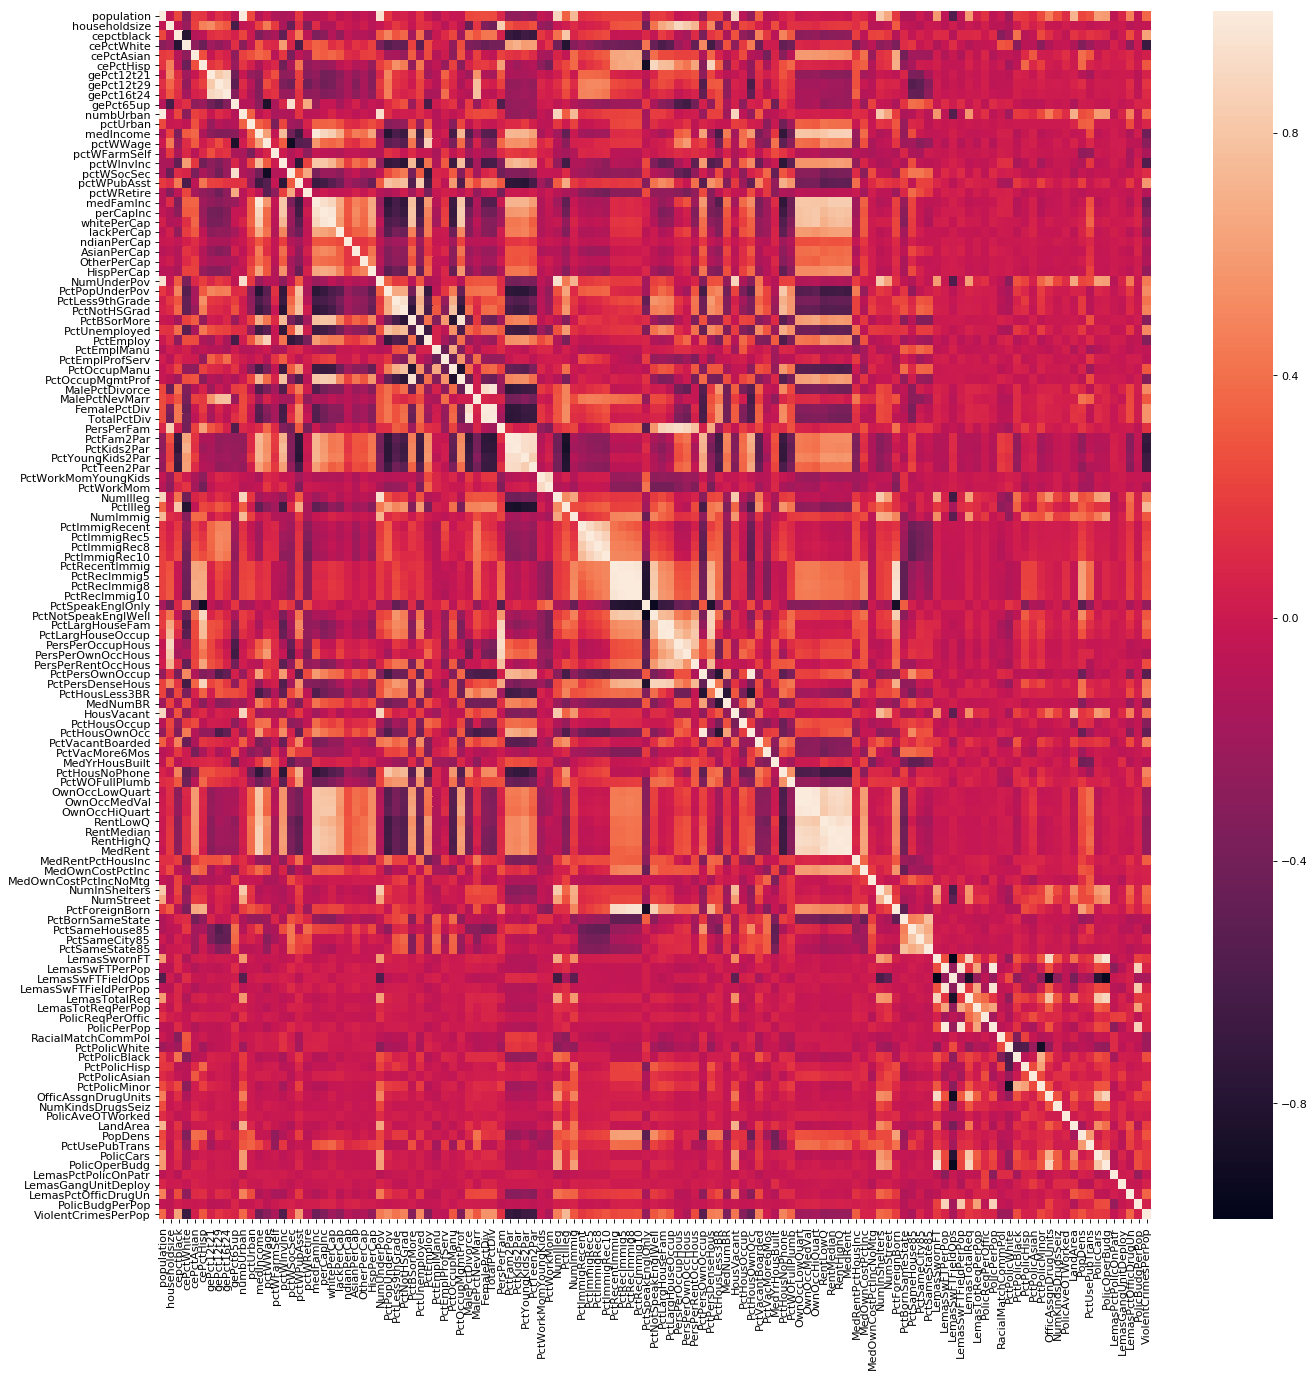

In [6]:
corr = df.corr()
plt.figure(num=None, figsize=(20,20), dpi=80, facecolor='w', edgecolor='k')
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)
plt.show()

Dropping the first 5 non predictive columns

In [35]:
df=df.drop(df.columns[:5],axis=1)

(d) Calculate the Coefficient of Variation for each feature.

In [36]:
x = int(np.sqrt(128))
cv=variation(df)
cvtop=sorted(cv,reverse=True)[:x]

In [108]:
cv

array([2.20294993, 0.3532097 , 1.41056656, 0.32370036, 1.35882134,
       1.61387296, 0.36574812, 0.29061999, 0.49503634, 0.42333552,
       2.00124163, 0.63868866, 0.579608  , 0.32762787, 0.69985456,
       0.35914986, 0.36842021, 0.6988552 , 0.3495514 , 0.52759954,
       0.54549659, 0.5074249 , 0.58932117, 0.80948203, 0.60604183,
       0.67047639, 0.47384086, 2.30439167, 0.75379109, 0.67543079,
       0.52815378, 0.57825579, 0.55599333, 0.34724014, 0.5104523 ,
       0.39812581, 0.5083338 , 0.422     , 0.39548416, 0.40371035,
       0.3591826 , 0.371375  , 0.31687526, 0.33052823, 0.3323925 ,
       0.32934323, 0.32846855, 0.33616412, 0.33263868, 2.99344555,
       0.91957222, 2.89976977, 0.6840295 , 0.58474358, 0.50478324,
       0.45555177, 1.29977426, 1.29730638, 1.28091166, 1.28371176,
       0.28860078, 1.45870069, 0.73435052, 0.75691886, 0.36682182,
       0.31932719, 0.46833631, 0.3502283 , 1.1269169 , 0.34828327,
       0.81068443, 1.9582885 , 0.26957935, 0.33745632, 1.06447

(e) Pick [√128] features with highest CV , and make scatter plots and box plots
 Can you draw conclusions about significance of those features, just by the scatter plots?

In [37]:
features=[]
for i in range(len(cv)):
    if cv[i] in cvtop:
        features.append(df.columns[i])
    

In [38]:
features

['population',
 'cePctHisp',
 'numbUrban',
 'NumUnderPov',
 'NumIlleg',
 'NumImmig',
 'HousVacant',
 'NumInShelters',
 'NumStreet',
 'LandArea',
 'LemasPctOfficDrugUn']

In [11]:
sns.set(style="ticks", color_codes=True)
g = sns.pairplot(df[features])

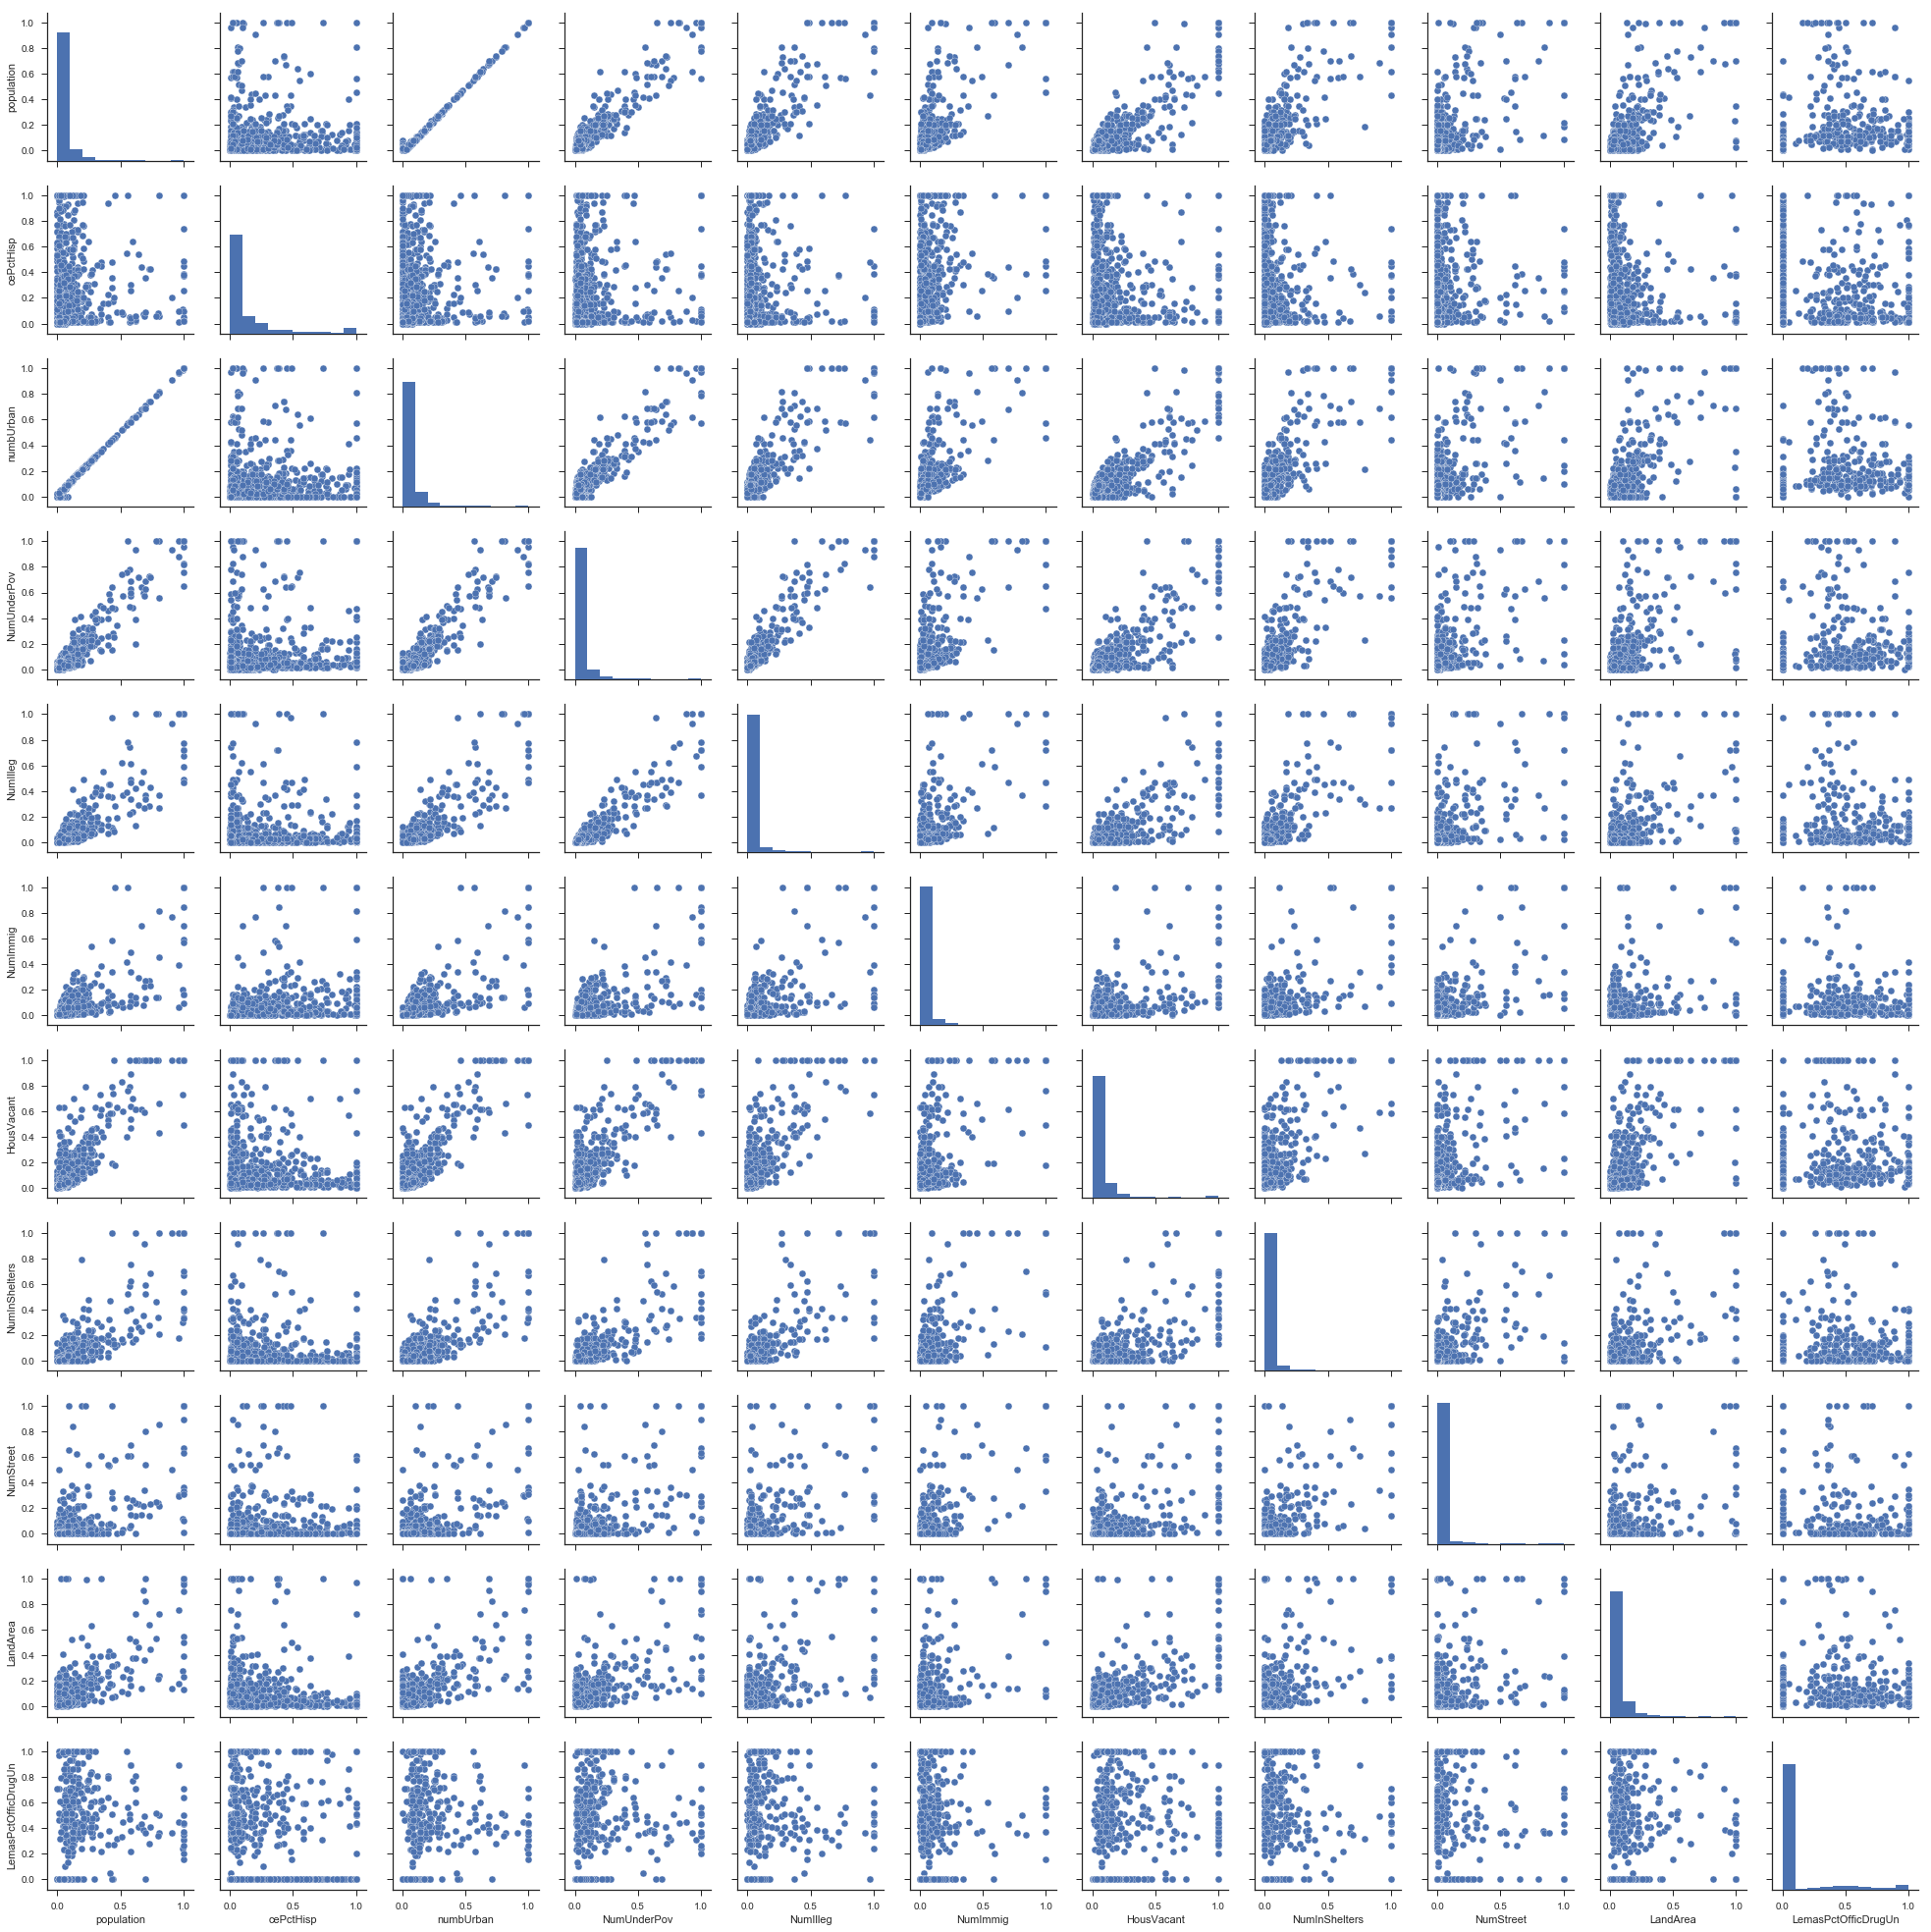

In [12]:
plt.show()

*The scatter plot shows a very clear linearity between features population and numbUrban and slight linearity between population(also numbUrban, since they seem corelated) and NumUnderPov*

<IPython.core.display.Javascript object>


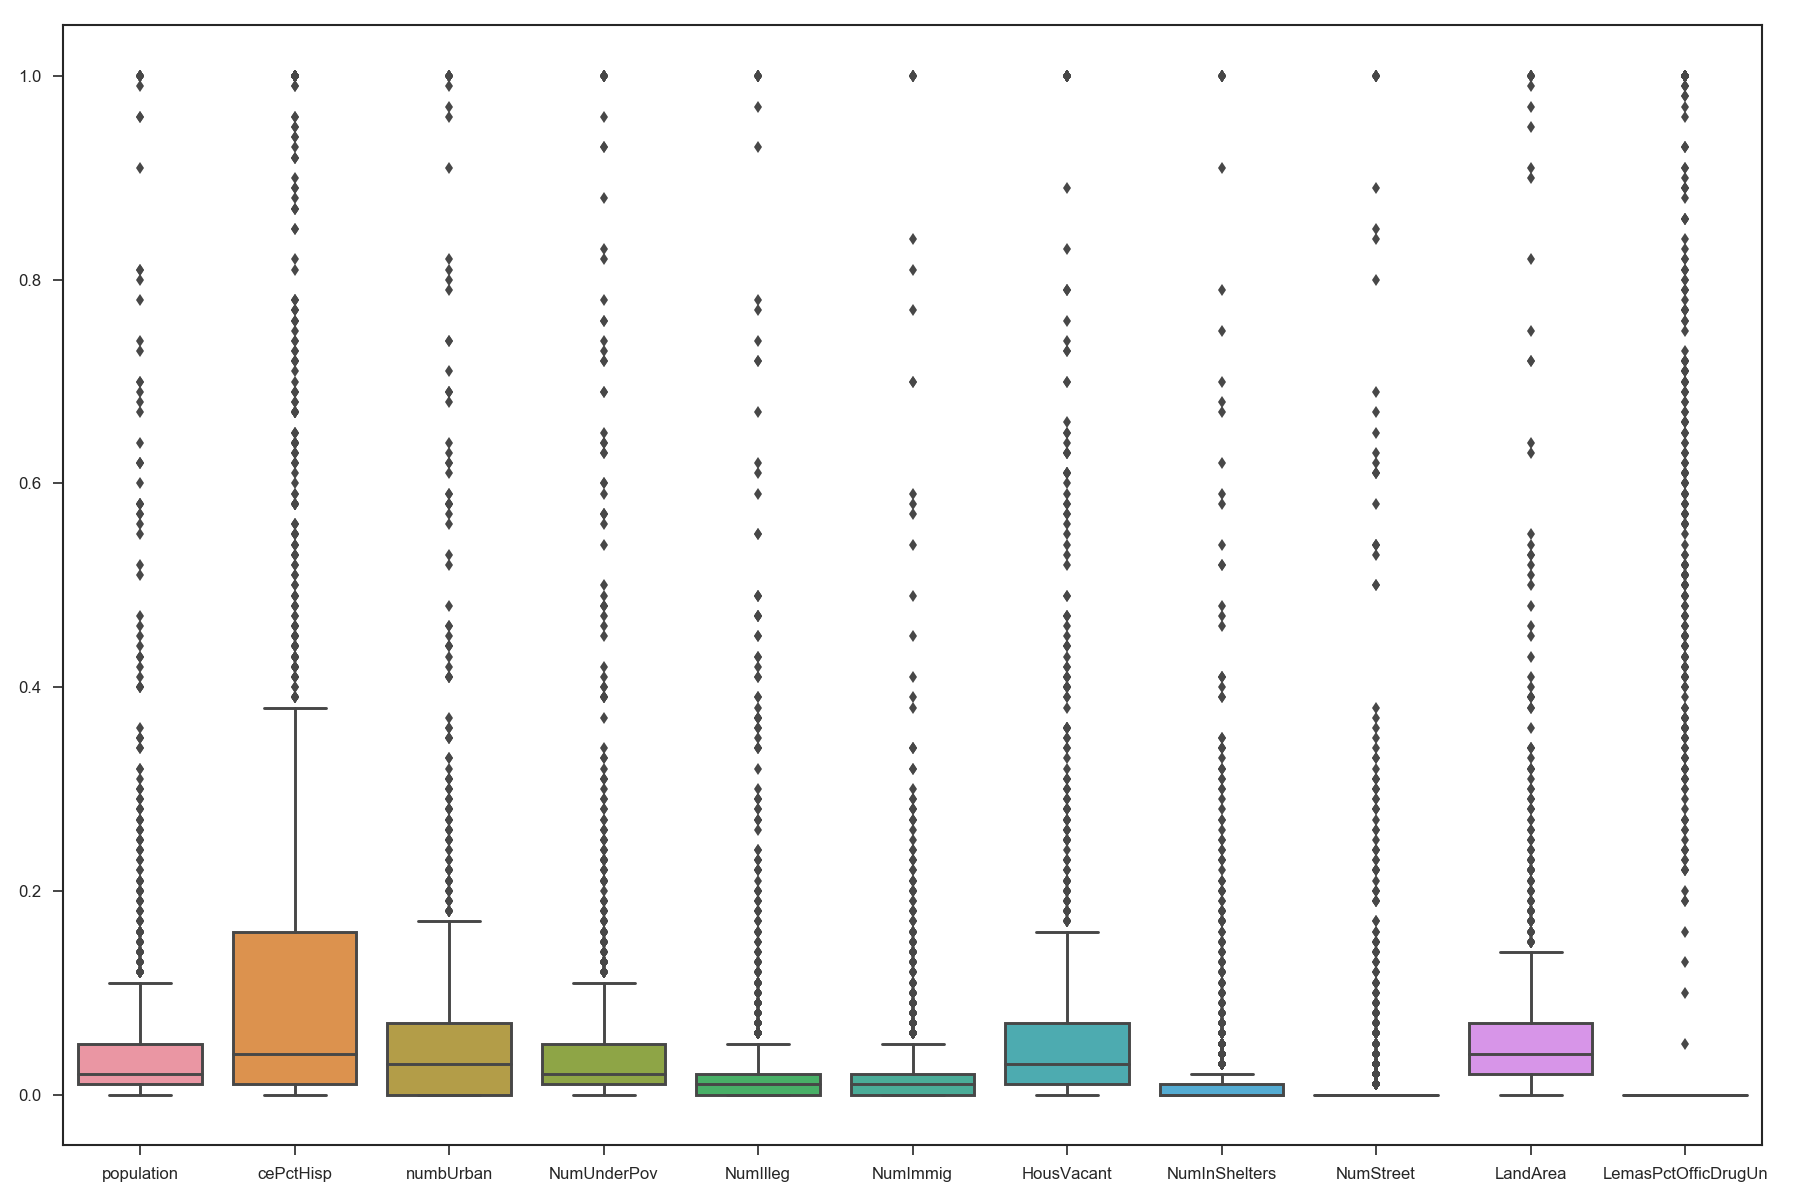

In [114]:
# Boxplots
plt.figure(figsize=(15,10))
ax = sns.boxplot(data = df[features])
boxes = ax.artists
plt.tight_layout()
plt.show()

*We can see from the boxplots that these features are skewed towards lower values and higher values only add up as few outliers*

Dividing dataset into test and train after imputation is complete

In [85]:
x_train=df.loc[:1494][df.columns[:-1]]
y_train=df.loc[:1494]['ViolentCrimesPerPop']
x_test=df.loc[1495:][df.columns[:-1]]
y_test=df.loc[1495:]['ViolentCrimesPerPop']

(f) Fit a linear model using least squares to the training set and report the test error.

In [87]:
regr = linear_model.LinearRegression(n_jobs=4)
regr.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=4, normalize=False)

In [88]:
y_pred = regr.predict(x_test)

print("\n Mean squared error: %.2f"% mean_squared_error(y_test, y_pred))
# Explained variance score: 1 is perfect prediction
print(' Variance score: %.2f' % r2_score(y_test, y_pred))


 Mean squared error: 0.79
 Variance score: -15.61


(g) Fit a ridge regression model on the training set, with λ chosen by cross-validation.
Report the test error obtained.

In [62]:
alphas = 10**np.linspace(10,-2,100)*0.5
reg=linear_model.RidgeCV(alphas=alphas, cv=5, fit_intercept=True, scoring="neg_mean_squared_error",normalize=True)
reg.fit(x_train,y_train)       

reg.alpha_  

0.06164233697210317

In [68]:
ridgebest_cv = Ridge(alpha = reg.alpha_, normalize = True)
ridgebest_cv.fit(x_train,y_train)
mse_ridge = mean_squared_error(y_test, ridgebest_cv.predict(x_test))
print('Ridge Regression Test MSE: %.4f' % (mse_ridge))

Ridge Regression Test MSE: 0.0175


(h) Fit a LASSO model on the training set, with λ chosen by cross-validation. Report
the test error obtained, along with a list of the variables selected by the model.
Repeat with normalized features. Report the test error for both cases and compare
them.

In [90]:
lasso_cv = LassoCV(alphas = None, cv = 10, max_iter = 100000)
lasso_cv.fit(x_train, y_train)


LassoCV(alphas=None, copy_X=True, cv=10, eps=0.001, fit_intercept=True,
    max_iter=100000, n_alphas=100, n_jobs=1, normalize=False,
    positive=False, precompute='auto', random_state=None,
    selection='cyclic', tol=0.0001, verbose=False)

In [100]:
lasso = Lasso(max_iter = 10000)
lasso.set_params(alpha=lasso_cv.alpha_) 
lasso.fit(x_train, y_train)
lasso_mse = mean_squared_error(y_test, lasso.predict(x_test))
coef_series = pd.Series(lasso.coef_, index=x_train.columns)
selected_features = coef_series[coef_series != 0].index.tolist()
print('Best Regularization Parameter for regular LASSO: %.4f' % lasso_cv.alpha_)
print('Regular LASSO Test MSE: %.4f' % (lasso_mse))
print('Features selected in regular LASSO Model\n')
print(selected_features)

Best Regularization Parameter for regular LASSO: 0.0001
Regular LASSO Test MSE: 0.0178
Features selected in regular LASSO Model

['cepctblack', 'cePctAsian', 'gePct12t21', 'gePct12t29', 'gePct65up', 'pctUrban', 'pctWWage', 'pctWFarmSelf', 'pctWInvInc', 'pctWSocSec', 'pctWPubAsst', 'pctWRetire', 'whitePerCap', 'lackPerCap', 'ndianPerCap', 'AsianPerCap', 'OtherPerCap', 'HispPerCap', 'PctPopUnderPov', 'PctLess9thGrade', 'PctBSorMore', 'PctEmploy', 'PctEmplManu', 'PctOccupManu', 'MalePctDivorce', 'MalePctNevMarr', 'FemalePctDiv', 'PctKids2Par', 'PctYoungKids2Par', 'PctTeen2Par', 'PctWorkMom', 'NumIlleg', 'PctIlleg', 'NumImmig', 'PctImmigRec10', 'PctRecImmig10', 'PctNotSpeakEnglWell', 'PctLargHouseOccup', 'PersPerOccupHous', 'PctPersOwnOccup', 'PctPersDenseHous', 'PctHousLess3BR', 'MedNumBR', 'HousVacant', 'PctHousOccup', 'PctVacantBoarded', 'PctVacMore6Mos', 'MedYrHousBuilt', 'PctHousNoPhone', 'PctWOFullPlumb', 'OwnOccLowQuart', 'RentLowQ', 'MedRent', 'MedRentPctHousInc', 'MedOwnCostPctInc

In [97]:
lasso_cvn = LassoCV(alphas = None, cv = 10, max_iter = 100000, normalize = True)
lasso_cvn.fit(x_train, y_train)


LassoCV(alphas=None, copy_X=True, cv=10, eps=0.001, fit_intercept=True,
    max_iter=100000, n_alphas=100, n_jobs=1, normalize=True,
    positive=False, precompute='auto', random_state=None,
    selection='cyclic', tol=0.0001, verbose=False)

In [99]:
lasso_n = Lasso(max_iter = 10000, normalize = True)
lasso_n.set_params(alpha=lasso_cvn.alpha_) 
lasso_n.fit(x_train, y_train)
lasso_mse_n = mean_squared_error(y_test, lasso_n.predict(x_test))
coef_series_n = pd.Series(lasso_n.coef_, index=x_train.columns)
selected_features_n = coef_series_n[coef_series_n != 0].index.tolist()
print('Best Regularization Parameter for Normalized LASSO: %.4f' % lasso_cvn.alpha_)
print('Normalized LASSO Test MSE: %.4f' % (lasso_mse))
print('Features selected in Normalized LASSO Model\n')
print(selected_features_n)

Best Regularization Parameter for Normalized LASSO: 0.0000
Normalized LASSO Test MSE: 0.0178
Features selected in Normalized LASSO Model

['cepctblack', 'cePctAsian', 'gePct12t21', 'gePct12t29', 'pctUrban', 'pctWWage', 'pctWFarmSelf', 'pctWInvInc', 'pctWSocSec', 'pctWPubAsst', 'pctWRetire', 'whitePerCap', 'lackPerCap', 'ndianPerCap', 'AsianPerCap', 'OtherPerCap', 'HispPerCap', 'PctPopUnderPov', 'PctLess9thGrade', 'PctEmploy', 'PctEmplManu', 'MalePctDivorce', 'MalePctNevMarr', 'FemalePctDiv', 'PctKids2Par', 'PctYoungKids2Par', 'PctTeen2Par', 'PctWorkMom', 'NumIlleg', 'PctIlleg', 'NumImmig', 'PctImmigRec10', 'PctRecImmig10', 'PctNotSpeakEnglWell', 'PctLargHouseOccup', 'PersPerOccupHous', 'PctPersOwnOccup', 'PctPersDenseHous', 'PctHousLess3BR', 'MedNumBR', 'HousVacant', 'PctHousOccup', 'PctVacantBoarded', 'PctVacMore6Mos', 'MedYrHousBuilt', 'PctHousNoPhone', 'PctWOFullPlumb', 'RentLowQ', 'MedRent', 'MedRentPctHousInc', 'MedOwnCostPctInc', 'MedOwnCostPctIncNoMtg', 'NumInShelters', 'NumStre

*The selected features with normalization (73) are less than features selected without it (77), but both give the same error rate. We can choose Normalized lasso since it has less complexity and same accuracy*

## Principal Component Analysis

(i) Fit a PCR model on the training set, with M (the number of principal components)
chosen by cross-validation. Report the test error obtained.


In [49]:
pca = PCA()
x_trainpca = pca.fit_transform(scale(x_train))

In [89]:
pd.DataFrame(pca.components_.T).shape

(122, 122)

Cross validation to find best Principal components

In [70]:
n = len(x_trainpca)
kfolds = model_selection.KFold(n_splits=10, shuffle=True, random_state=1)

regr = LinearRegression()
mse = []

#Base MSE with intercept
score = -1*model_selection.cross_val_score(regr, np.ones((n,1)), y_train.ravel(), cv=kfolds, scoring='neg_mean_squared_error').mean()    
mse.append(score)


for i in np.arange(1, 25):
    score = -1*model_selection.cross_val_score(regr, x_trainpca[:,:i], y_train.ravel(), cv=kfolds, scoring='neg_mean_squared_error').mean()
    mse.append(score)


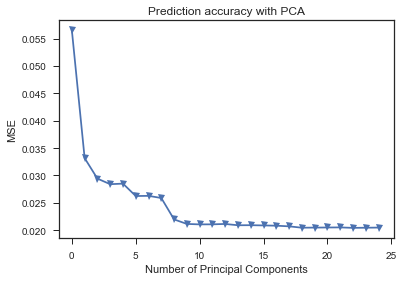

In [71]:
plt.plot(np.array(mse), '-v')
plt.xlabel('Number of Principal Components')
plt.ylabel('MSE')
plt.title('Prediction accuracy with PCA')
plt.xlim(xmin=-1);
plt.show()

*Since, we get the best accuracy starting 9 PCAs we train our model with those components*

In [75]:
x_testpca= pca.transform(scale(x_test))[:,:9]

In [77]:
regr = LinearRegression()
regr.fit(x_trainpca[:,:9], y_train)
pred = regr.predict(x_testpca)
mse = mean_squared_error(y_test, pred)
print('PCR Test MSE: %.4f' % (mse))

PCR Test MSE: 0.0181


*The error is similar to Lasso and Ridge but PCA reduces interpretability and hence not recommended if there is insignificant improvement in the model*

## Boosting

(j) In this section, we would like to fit a boosting tree to the data. As in classification
trees, one can use any type of regression at each node to build a multivariate
regression tree. Because the number of variables is large in this problem, one
can use L1-penalized regression at each node. Such a tree is called L1 penalized
gradient boosting tree. You can use XGBoost to fit the model tree. Determine α
(the regularization term) using cross-validation.

In [24]:

xgdmat=xgb.DMatrix(x_train,y_train)
our_params={'eta':0.1,'seed':0,'subsample':0.8,'colsample_bytree':0.8,'objective':'reg:linear','max_depth':3,'min_child_weight':1}
final_gb=xgb.train(our_params,xgdmat)
tesdmat=xgb.DMatrix(x_test)
y_pred=final_gb.predict(tesdmat)
xgbr = xgb.XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75,colsample_bytree=1, max_depth=7)

In [78]:
# Grid Search Params
params = {
    'reg_alpha': alphas,   
}

xgbReg = XGBRegressor(nthread= 4, objective= 'reg:linear') 
grid = GridSearchCV(estimator = xgbReg, param_grid ={'reg_alpha': alphas}, scoring='neg_mean_squared_error', n_jobs=4, iid=False, cv=5)
grid.fit(x_train,y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=4,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1),
       fit_params={}, iid=False, n_jobs=4,
       param_grid={'reg_alpha': array([5.00000e+09, 3.78232e+09, ..., 6.60971e-03, 5.00000e-03])},
       pre_dispatch='2*n_jobs', refit=True,
       scoring='neg_mean_squared_error', verbose=0)

Taking the best L1 parameter

In [79]:
best_l1 = list(grid.best_params_.values())[0]
print('Best L1 Regularization Parameter for XGBoost: %.4f' % best_l1)

Best L1 Regularization Parameter for XGBoost: 0.3290


In [81]:
gbm = XGBRegressor(reg_alpha = best_l1)
gbm.fit(x_train,y_train)
predictions = gbm.predict(x_test)
XGBoost_mse = mean_squared_error(y_test, predictions)
print('XGBoost Test MSE: %.4f' % (XGBoost_mse))

XGBoost Test MSE: 0.0163


## Results

Finally, the MSE values from our different models are :
* Linear Regression-0.79
* Ridge-0.0175
* Lasso(both)-0.0178
* PCR- 0.0181
* XGBoost- 0.0163

We can conclude that XGBoost gives us best accuracy for this model